In [3]:
pip install matplotlib

  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached kiwisolver-1.4.4-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
  Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import matplotlib.lines as lines
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diff

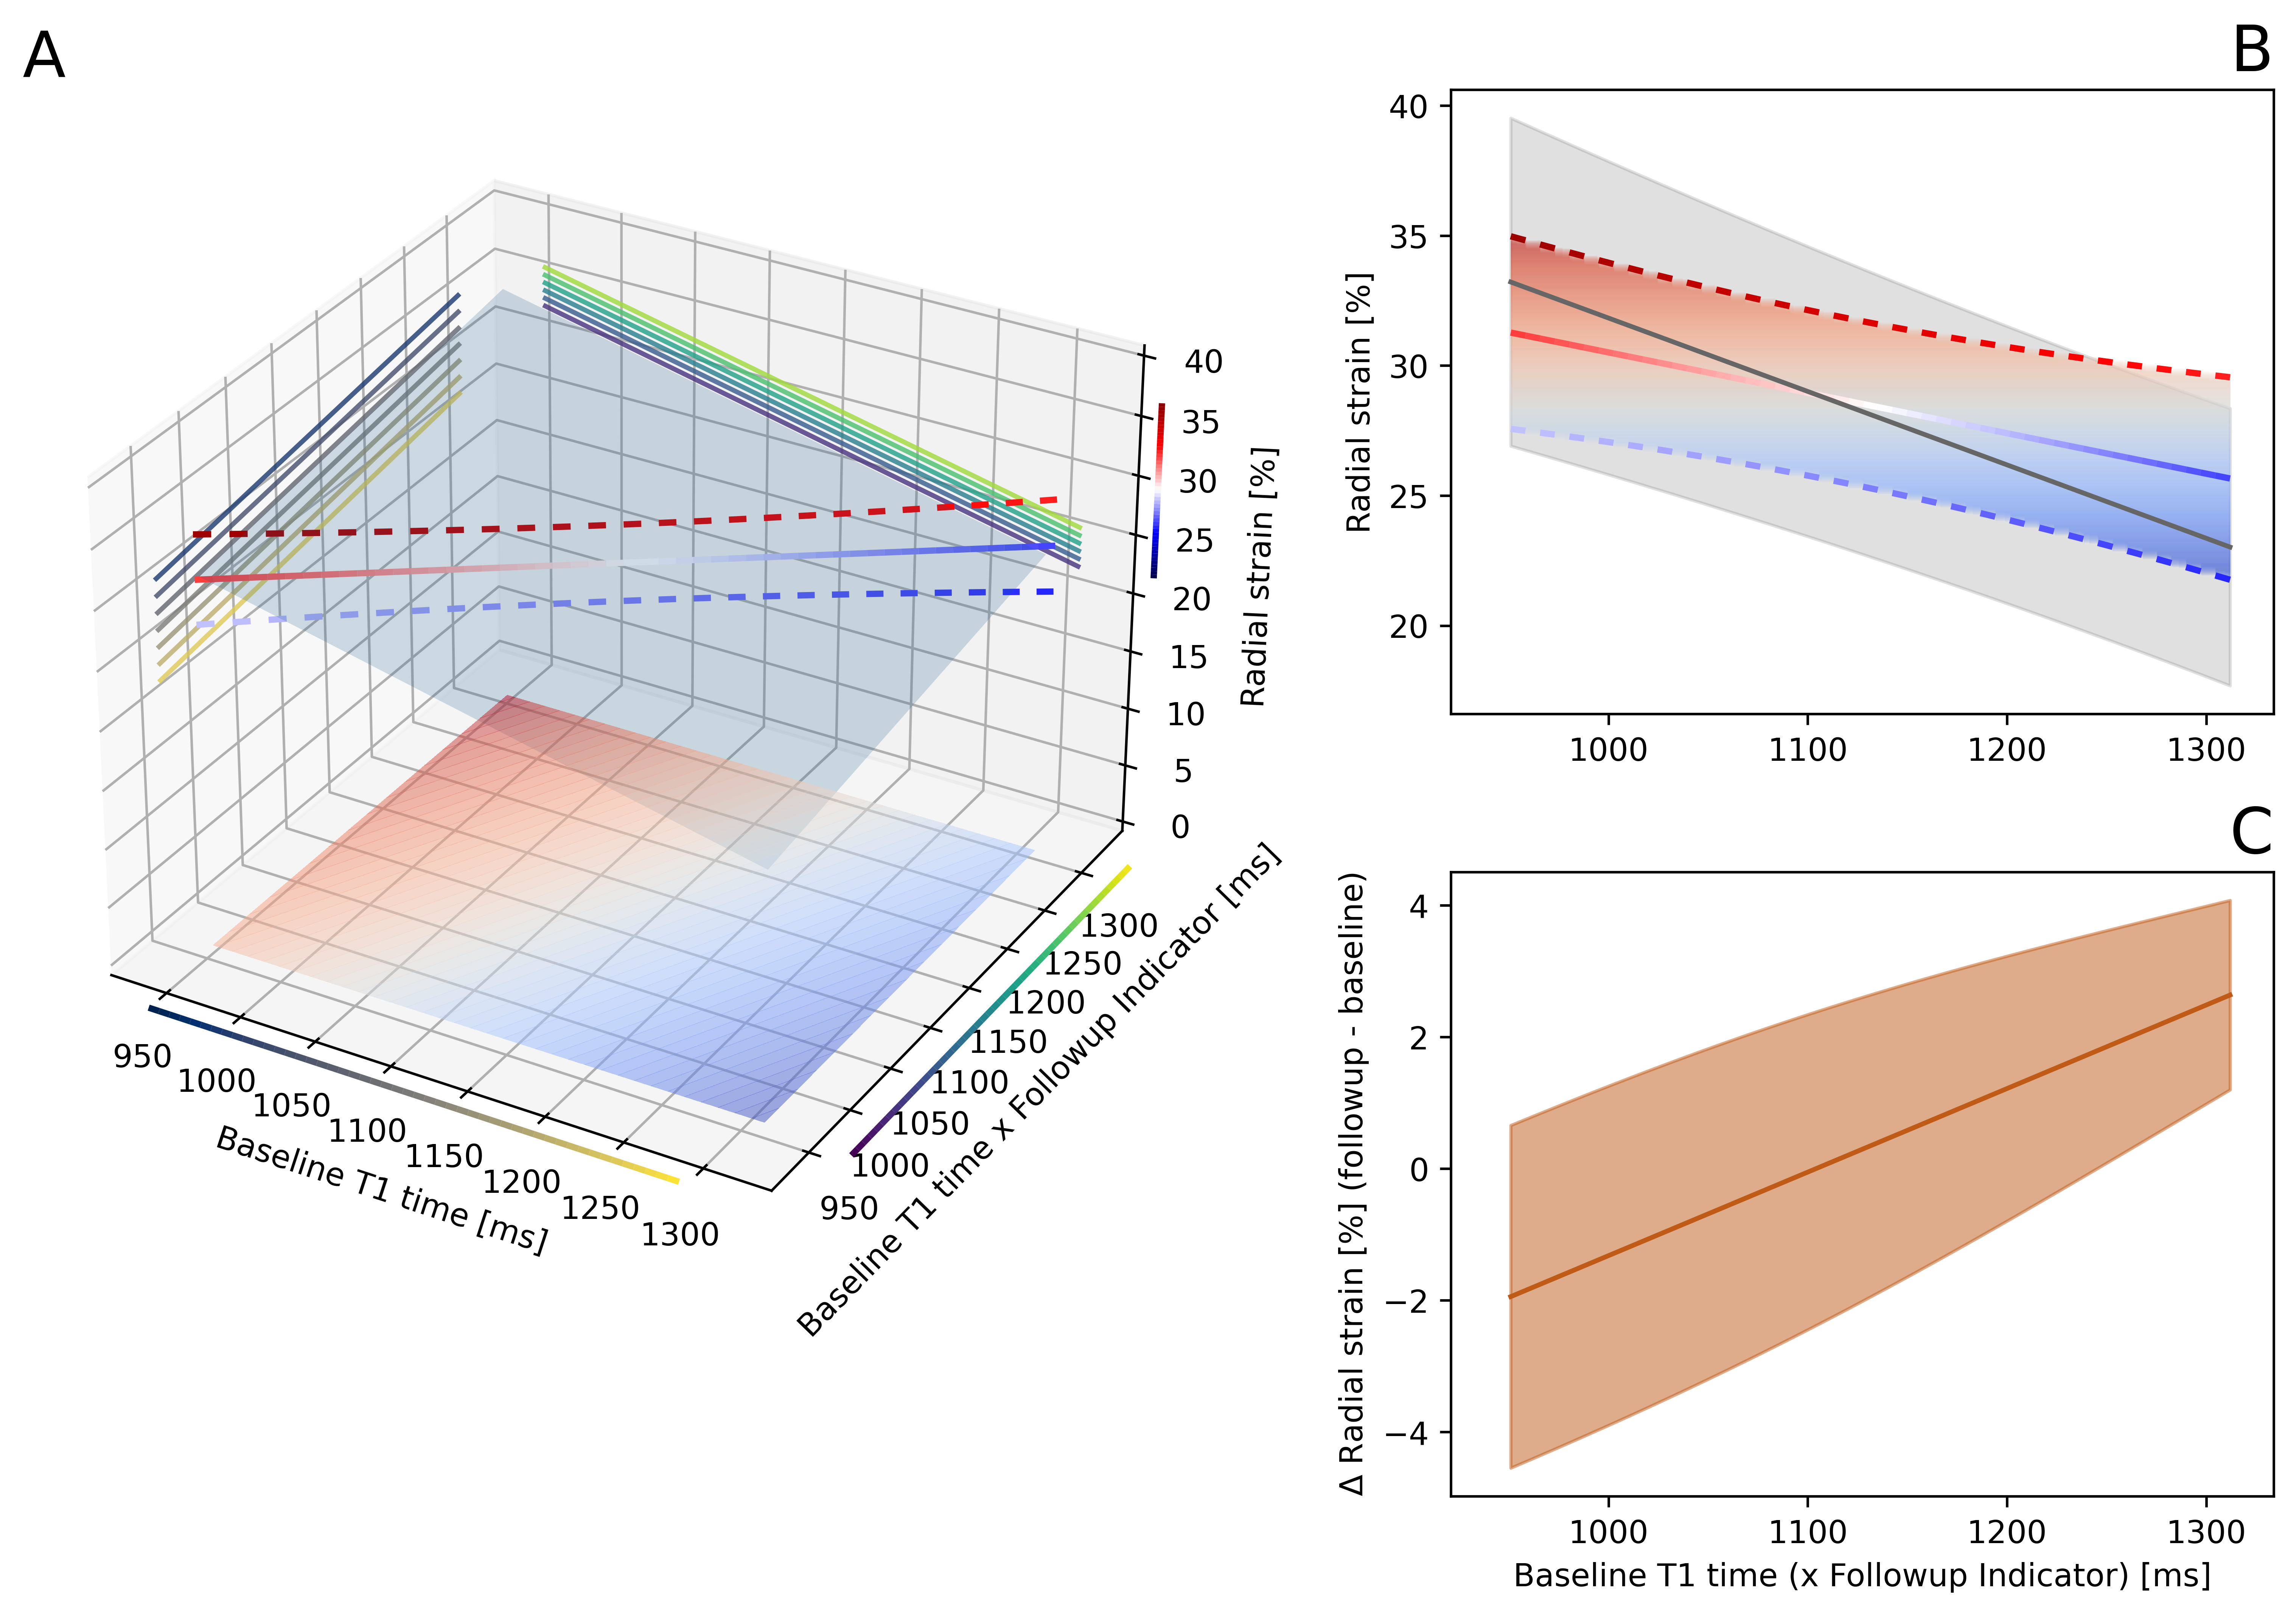

In [105]:
df_bd = pd.read_stata('tmp/margins_base_prog_fup.dta')
df_db = pd.read_stata('tmp/margins_delta_base.dta')

margins = df_bd[[col for col in df_bd.columns.tolist() if 'margin' in col]]
ci_lb = df_bd[[col for col in df_bd.columns.tolist() if 'ci_lb' in col]]
ci_ub = df_bd[[col for col in df_bd.columns.tolist() if 'ci_ub' in col]]

diag_marg = margins.values[tuple([np.arange(margins.shape[0])]*2)]
diag_ci_lb = ci_lb.values[tuple([np.arange(ci_lb.shape[0])]*2)]
diag_ci_ub = ci_ub.values[tuple([np.arange(ci_ub.shape[0])]*2)]



int_base_t1_time = df_bd['int_base_t1_fup']
base_t1_time = df_db['base_t1_time']

# define figure
fig = plt.figure(layout="constrained", figsize=[10, 7], dpi=600)
gs = GridSpec(2, 2, figure=fig, wspace=0.1, width_ratios=[10, 7])

ax = fig.add_subplot(gs[:, 0],projection='3d', anchor='NW')
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)


X, Y = int_base_t1_time.values, base_t1_time.values
X_min = X.min()
X_max = X.max()
X_range = abs(X_min - X_max)

xt = 0.1
X_min -= xt * X_range
X_max += xt * X_range

Y_min = Y.min()
Y_max = Y.max()
Y_range = abs(Y_min - Y_max)
Y_min -= xt * Y_range
Y_max += xt * Y_range

X, Y = np.meshgrid(X,Y)
X_0, Y_0 = X[int(Y.shape[1]/2), :][np.newaxis, :], Y[int(Y.shape[1]/2), :][np.newaxis, :]

ax.plot_surface(X, Y, margins.values,
                cstride=2,
                rstride=2,
                alpha=0.2,
                zorder=2,
               )

#
# plot bars
#
x_cb = int_base_t1_time.values
y_cb = base_t1_time.values
z_cb = np.linspace(margins.values.min(),margins.values.max(),50)

# plot X bar



# get points
points = np.array([y_cb,
                   np.ones_like(y_cb) * X_min - xt * X_range,
                   np.zeros_like(y_cb)]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = Line3DCollection(segments, cmap=cm.cividis,)
lc.set_array(x_cb)
lc.set_linewidth(2)
ax.add_collection(lc)


# plot Y bar

# get points
points = np.array([np.ones_like(x_cb) * Y_max + xt * Y_range,
                   x_cb,
                   np.zeros_like(x_cb)]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = Line3DCollection(segments, cmap=cm.viridis,)
lc.set_array(y_cb)
lc.set_linewidth(2)
ax.add_collection(lc)

# plot Z bar

# get points
points = np.array([np.ones_like(z_cb) * Y_max + 0.5 * xt * Y_range,
                   np.ones_like(z_cb) * X_max + 0.5 * xt * X_range,
                   z_cb]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = Line3DCollection(segments, cmap=cm.seismic,)
lc.set_array(z_cb)
lc.set_linewidth(2)
ax.add_collection(lc)

# Plot line 
x_cb = X[0]
#ax.plot(x_cb, x_cb, diag_marg,c=diag_marg, cmap=cm.coolwarm)

for arr, stride, zorder in [(diag_ci_lb, 'dashed', 1), (diag_ci_ub, 'dashed', 3), (diag_marg, 'solid', 3) ]:
    points_line = np.array([x_cb,
                       x_cb,
                       arr]).T.reshape(-1, 1, 3)

    segments_line = np.concatenate([points_line[:-1], points_line[1:]], axis=1)
    if stride == 'dashed':
        segments_line = segments_line[::2]

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(margins.values.min(), margins.values.max())
    lc = Line3DCollection(segments_line, cmap='seismic', norm=norm, alpha=1, zorder=zorder)
    # Set the values used for colormapping
    lc.set_array(arr)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)

#ax.plot(ys=delta_t1_time.values, xs=np.ones_like(x_cb) * Y_max,  zs=0, zdir='z',)
#ax.plot_wireframe(X, Y, ci_lb.T.values, rcount=10, ccount=10, alpha=0.2)
#ax.plot_wireframe(X, Y, ci_ub.T.values, rcount=10, ccount=10, alpha=0.2)
x_ax = ax.contour(X, Y, margins.values, zdir='x', offset=Y_min, cmap=cm.cividis, alpha=0.8)
y_ax = ax.contour(X, Y, margins.values, zdir='y', offset=X_max, cmap=cm.viridis, alpha=0.8)
z_ax = ax.contourf(X, Y, margins.values, zdir='z', levels=50, offset=0, cmap=cm.coolwarm, alpha=0.5)


# setting labels
ax.set_xlabel('Baseline T1 time [ms]')
ax.set_xlim(Y_min, Y_max)
ax.set_ylabel(r'Baseline T1 time x Followup Indicator [ms]')
ax.set_ylim(X_min, X_max)
ax.set_zlabel('Radial strain [%]')
ax.set_zlim(0, 40)
# fig.colorbar(z_ax, shrink=0.4, aspect=5, location='bottom')
# fig.colorbar(x_ax, shrink=0.4, aspect=5, location='left')
# fig.colorbar(y_ax, shrink=0.4, aspect=5, location='right')




df_prog_base = pd.read_stata('tmp/margins_base_prog_bl.dta')
df_prog_fup = pd.read_stata('tmp/margins_base_prog_fup.dta')
df_prog_base
df_prog_fup




df_sub = df_prog_fup.apply(lambda row: row - df_prog_base.iloc[0], axis=1)
df_sub['int_base_t1_fup'] = df_prog_fup['int_base_t1_fup']

margins = df_prog_fup[[col for col in df_prog_fup.columns.tolist() if 'margin' in col]]
ci_lb = df_prog_fup[[col for col in df_prog_fup.columns.tolist() if 'ci_lb' in col]]
ci_ub = df_prog_fup[[col for col in df_prog_fup.columns.tolist() if 'ci_ub' in col]]

diag_marg = margins.values[[np.arange(margins.shape[0])]*2]
diag_ci_lb = ci_lb.values[[np.arange(ci_lb.shape[0])]*2]
diag_ci_ub = ci_ub.values[[np.arange(ci_ub.shape[0])]*2]

base_margins = df_prog_base[[col for col in df_prog_base.columns.tolist() if 'margin' in col]].squeeze()
base_mcilb = df_prog_base[[col for col in df_prog_base.columns.tolist() if 'ci_lb' in col]].squeeze()
base_mciub = df_prog_base[[col for col in df_prog_base.columns.tolist() if 'ci_ub' in col]].squeeze()


sub_marg = diag_marg - base_margins

sub_ci_lb = diag_ci_lb - base_mcilb
sub_ci_ub = diag_ci_ub - base_mciub

int_base_t1_time = df_sub['int_base_t1_fup']
x_cb = int_base_t1_time.values

cmap = plt.get_cmap("Accent_r")


# plot baseline strain

#ax1.set_xlabel('Baseline T1 time [ms]')
ax1.set_xlim(Y_min, Y_max)
ax1.set_ylabel('Radial strain [%]')
#ax1.set_ylim(0, 40)

ax1.plot(x_cb, base_margins, alpha = 1, color=cmap(0), zorder=4,)



ax1.fill_between(x_cb, base_mcilb, base_mciub, alpha = 0.2,zorder=1, color=cmap(0))

# plot the diag strain

for arr, stride in [(diag_ci_lb, 'dashed'), (diag_ci_ub, 'dashed'), (diag_marg, 'solid') ]:
    points_line = np.array([x_cb,
                       arr]).T.reshape(-1, 1, 2)

    
    segments_line = np.concatenate([points_line[:-1], points_line[1:]], axis=1)
    if stride == 'dashed':
        segments_line = segments_line[::2]


    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(margins.values.min(), margins.values.max())
    lc = LineCollection(segments_line, cmap='seismic', norm=norm, alpha=1., zorder=3)
    # Set the values used for colormapping
    lc.set_array(arr)
    lc.set_linewidth(2)
    lc.set_linestyle(stride)
    line = ax1.add_collection(lc)



#ax1.plot(x_cb, diag_marg, alpha = 1, color=cmap(2))
#ax1.fill_between(x_cb, diag_ci_lb, diag_ci_ub, alpha = 0.5, color=cmap(2))

delta=0.01

z_range = np.arange(diag_ci_lb.min(), diag_ci_ub.max() ,step=delta)
z_range = np.linspace(diag_ci_lb.min(), diag_ci_ub.max(), 500)
cont_x, cont_y = np.meshgrid(x_cb, z_range)

maskout = np.logical_or(cont_y < diag_ci_lb, cont_y > diag_ci_ub)

z_unmasked = np.tile(z_range, (cont_x.shape[1], 1)).T
cont_z = np.ma.array(z_unmasked)
cont_z[maskout] = np.ma.masked


ax1.contour(cont_x, cont_y, cont_z, levels=500, cmap ='coolwarm', norm=norm, zorder=2, alpha=0.1, linewidths=3)

#fup_0_margins = np.ones_like(margins[1]) * margins[1, np.abs(x_cb - 0) < 1e-6]

#ax1.errorbar(0, base_margins[0],
#             yerr=fup_0_margins[0] - base_margins[0],
#             lolims=True,
#            dash_capstyle='butt')



#ax2plot(x_cb, sub_margins, alpha = 1, color=cmap(1)
#ax1.fill_between(x_cb, base_mcilb, base_mciub, alpha = 0.5, color=cmap(1)


# plot difference

ax2.plot(x_cb, sub_marg, alpha = 1, color=cmap(1))
ax2.fill_between(x_cb, sub_ci_lb, sub_ci_ub, alpha = 0.5, color=cmap(1))

ax2.set_xlabel(r'Baseline T1 time (x Followup Indicator) [ms]')
ax2.set_xlim(Y_min, Y_max)
ax2.set_ylabel(r'$\Delta$ Radial strain [%] (followup - baseline)')


ax.set_title('A', loc='left', fontsize=20, verticalalignment='top')
ax1.set_title('B', loc='right', fontsize=20)
ax2.set_title('C', loc='right', fontsize=20)

fig.savefig('tmp/prog_base_3d.svg', bbox_inches='tight')
fig.show()


In [67]:
df_db

,i,_margin1,_ci_lb1,_ci_ub1,_margin2,_ci_lb2,_ci_ub2,_margin3,_ci_lb3,_ci_ub3,...,_margin48,_ci_lb48,_ci_ub48,_margin49,_ci_lb49,_ci_ub49,_margin50,_ci_lb50,_ci_ub50,base_t1_time
0,1,32.548260,28.659771,36.436752,32.449409,28.579384,36.319435,32.350559,28.498625,36.202488,...,27.902229,24.408669,31.395790,27.803377,24.306566,31.300188,27.704525,24.203960,31.205090,955.356384
1,2,32.342491,28.493488,36.191498,32.243641,28.413067,36.074215,32.144791,28.332270,35.957310,...,27.696461,24.235161,31.157761,27.597609,24.132778,31.062439,27.498756,24.029892,30.967623,962.378113
2,3,32.136723,28.326101,35.947342,32.037868,28.245638,35.830105,31.939018,28.164795,35.713242,...,27.490690,24.060276,30.921104,27.391838,23.957609,30.826065,27.292986,23.854435,30.731537,969.399902
3,4,31.930954,28.157578,35.704330,31.832102,28.077066,35.587135,31.733250,27.996174,35.470329,...,27.284922,23.883976,30.685865,27.186069,23.781025,30.591114,27.087217,23.677561,30.496876,976.421631
4,5,31.725185,27.987885,35.462486,31.626333,27.907318,35.345348,31.527483,27.826366,35.228600,...,27.079153,23.706226,30.452080,26.980301,23.602985,30.357618,26.881451,23.499228,30.263672,983.443359
5,6,31.519417,27.816986,35.221848,31.420567,27.736359,35.104774,31.321714,27.655340,34.988087,...,26.873384,23.526989,30.219780,26.774534,23.423456,30.125610,26.675682,23.319403,30.031961,990.465088
6,7,31.313646,27.644844,34.982449,31.214794,27.564148,34.865440,31.115942,27.483057,34.748829,...,26.667614,23.346226,29.989002,26.568762,23.242397,29.895128,26.469912,23.138046,29.801775,997.486877
7,8,31.107878,27.471432,34.744324,31.009027,27.390659,34.627392,30.910175,27.309488,34.510860,...,26.461845,23.163906,29.759787,26.362993,23.059780,29.666208,26.264143,22.955130,29.573154,1004.508606
8,9,30.902109,27.296709,34.507511,30.803259,27.215855,34.390663,30.704407,27.134594,34.274220,...,26.256077,22.979994,29.532162,26.157227,22.875570,29.438881,26.058374,22.770620,29.346128,1011.530273
9,10,30.696342,27.120646,34.272038,30.597490,27.039698,34.155281,30.498638,26.958342,34.038937,...,26.050310,22.794458,29.306160,25.951458,22.689735,29.213179,25.852606,22.584484,29.120728,1018.552002


In [91]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = delta_t1_time.values, base_t1_time.values
X_min = X.min()
X_max = X.max()
X_range = abs(X_min - X_max)

xt = 0.1
X_min -= xt * X_range
X_max += xt * X_range

Y_min = Y.min()
Y_max = Y.max()
Y_range = abs(Y_min - Y_max)
Y_min -= xt * Y_range
Y_max += xt * Y_range

X, Y = np.meshgrid(X,Y)
X_0, Y_0 = X[int(Y.shape[1]/2), :][np.newaxis, :], Y[int(Y.shape[1]/2), :][np.newaxis, :]

ax.plot_surface(Y, X, margins.values,
                cstride=2,
                rstride=2,
                alpha=0.7,
               )

#
# plot bars
#
x_cb = delta_t1_time.values
y_cb = base_t1_time.values
z_cb = np.linspace(margins.values.min(),margins.values.max(),50)

# plot X bar

# get points
points = np.array([y_cb,
                   np.ones_like(y_cb) * X_min - xt * X_range,
                   np.zeros_like(y_cb)]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = Line3DCollection(segments, cmap=cm.cividis,)
lc.set_array(x_cb)
lc.set_linewidth(2)
ax.add_collection(lc)


# plot Y bar

# get points
points = np.array([np.ones_like(x_cb) * Y_max + xt * Y_range,
                   x_cb,
                   np.zeros_like(x_cb)]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = Line3DCollection(segments, cmap=cm.viridis,)
lc.set_array(y_cb)
lc.set_linewidth(2)
ax.add_collection(lc)

# plot Z bar

# get points
points = np.array([np.ones_like(z_cb) * Y_max + 0.5 * xt * Y_range,
                   np.ones_like(z_cb) * X_max + 0.5 * xt * X_range,
                   z_cb]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = Line3DCollection(segments, cmap=cm.coolwarm,)
lc.set_array(z_cb)
lc.set_linewidth(2)
ax.add_collection(lc)


#ax.plot(ys=delta_t1_time.values, xs=np.ones_like(x_cb) * Y_max,  zs=0, zdir='z',)
#ax.plot_wireframe(X, Y, ci_lb.T.values, rcount=10, ccount=10, alpha=0.2)
#ax.plot_wireframe(X, Y, ci_ub.T.values, rcount=10, ccount=10, alpha=0.2)

y_ax = ax.contour(Y, X, margins.values, zdir='y', offset=X_max, cmap=cm.viridis, alpha=0.8)
x_ax = ax.contour(Y, X, margins.values, zdir='x', offset=Y_min, cmap=cm.cividis, alpha=0.8)
z_ax = ax.contourf(Y, X, margins.values, zdir='z', levels=50, offset=0, cmap=cm.coolwarm, alpha=0.5)


# setting labels
ax.set_ylabel(r'$\Delta$ T1 time [ms]')
ax.set_ylim(X_min, X_max)
ax.set_xlabel('Baseline T1 time [ms]')
ax.set_xlim(Y_min, Y_max)
ax.set_zlabel('Radial strain [%]')
ax.set_zlim(0, 40)
# fig.colorbar(z_ax, shrink=0.4, aspect=5, location='bottom')
# fig.colorbar(x_ax, shrink=0.4, aspect=5, location='left')
# fig.colorbar(y_ax, shrink=0.4, aspect=5, location='right')


fig.savefig('tmp/base_delta_3d.svg', bbox_inches='tight')
fig.show()
plt.close()

In [93]:
df_bd = pd.read_stata('tmp/margins_base_delta.dta')
df_db = pd.read_stata('tmp/margins_delta_base.dta')
df_fd = pd.read_stata('tmp/margins_delta_followup.dta')
margins = df_bd[[col for col in df_bd.columns.tolist() if 'margin' in col]]
ci_lb = df_bd[[col for col in df_bd.columns.tolist() if 'ci_lb' in col]]
ci_ub = df_bd[[col for col in df_bd.columns.tolist() if 'ci_ub' in col]]
delta_t1_time = df_bd['delta_t1_time']
base_t1_time = df_db['base_t1_time']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = delta_t1_time.values, base_t1_time.values
X_min = X.min()
X_max = X.max()
X_range = abs(X_min - X_max)

xt = 0.1
X_min -= xt * X_range
X_max += xt * X_range

Y_min = Y.min()
Y_max = Y.max()
Y_range = abs(Y_min - Y_max)
Y_min -= xt * Y_range
Y_max += xt * Y_range

X, Y = np.meshgrid(X,Y)
X_0, Y_0 = X[int(Y.shape[1]/2), :][np.newaxis, :], Y[int(Y.shape[1]/2), :][np.newaxis, :]

ax.plot_surface(Y, X, margins.values,
                cstride=2,
                rstride=2,
                alpha=0.7,
               )

#
# plot bars
#
x_cb = delta_t1_time.values
y_cb = base_t1_time.values
z_cb = np.linspace(margins.values.min(),margins.values.max(),50)

# plot X bar

# get points
points = np.array([y_cb,
                   np.ones_like(y_cb) * X_min - xt * X_range,
                   np.zeros_like(y_cb)]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = Line3DCollection(segments, cmap=cm.cividis,)
lc.set_array(x_cb)
lc.set_linewidth(2)
ax.add_collection(lc)


# plot Y bar

# get points
points = np.array([np.ones_like(x_cb) * Y_max + xt * Y_range,
                   x_cb,
                   np.zeros_like(x_cb)]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = Line3DCollection(segments, cmap=cm.viridis,)
lc.set_array(y_cb)
lc.set_linewidth(2)
ax.add_collection(lc)

# plot Z bar

# get points
points = np.array([np.ones_like(z_cb) * Y_max + 0.5 * xt * Y_range,
                   np.ones_like(z_cb) * X_max + 0.5 * xt * X_range,
                   z_cb]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = Line3DCollection(segments, cmap=cm.coolwarm,)
lc.set_array(z_cb)
lc.set_linewidth(2)
ax.add_collection(lc)


#ax.plot(ys=delta_t1_time.values, xs=np.ones_like(x_cb) * Y_max,  zs=0, zdir='z',)
#ax.plot_wireframe(X, Y, ci_lb.T.values, rcount=10, ccount=10, alpha=0.2)
#ax.plot_wireframe(X, Y, ci_ub.T.values, rcount=10, ccount=10, alpha=0.2)

y_ax = ax.contour(Y, X, margins.values, zdir='y', offset=X_max, cmap=cm.viridis, alpha=0.8)
x_ax = ax.contour(Y, X, margins.values, zdir='x', offset=Y_min, cmap=cm.cividis, alpha=0.8)
z_ax = ax.contourf(Y, X, margins.values, zdir='z', levels=50, offset=0, cmap=cm.coolwarm, alpha=0.5)


# setting labels
ax.set_ylabel(r'$\Delta$ T1 time [ms]')
ax.set_ylim(X_min, X_max)
ax.set_xlabel('Baseline T1 time [ms]')
ax.set_xlim(Y_min, Y_max)
ax.set_zlabel('Radial strain [%]')
ax.set_zlim(0, 40)
# fig.colorbar(z_ax, shrink=0.4, aspect=5, location='bottom')
# fig.colorbar(x_ax, shrink=0.4, aspect=5, location='left')
# fig.colorbar(y_ax, shrink=0.4, aspect=5, location='right')


fig.savefig('tmp/base_delta_3d.svg', bbox_inches='tight')
fig.show()
plt.close()

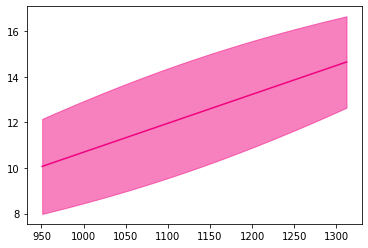

In [124]:
def add_interval(ax, x_data, y_data, y_height):
    line = ax.errorbar(x_data, y_data, yerr=y_height, uplims=True)
    return ax

df_prog_base = pd.read_stata('tmp/margins_base_prog_base.dta')
df_prog_fup = pd.read_stata('tmp/margins_base_prog_fup_median.dta')
df_prog_base
df_prog_fup




df_sub = df_prog_fup.apply(lambda row: row - df_prog_base.iloc[0], axis=1)
df_sub['int_base_t1_fup'] = df_prog_fup['int_base_t1_fup']

margins = df_sub[[col for col in df_sub.columns.tolist() if 'margin' in col]].squeeze()
ci_lb = df_sub[[col for col in df_sub.columns.tolist() if 'ci_lb' in col]].squeeze()
ci_ub = df_sub[[col for col in df_sub.columns.tolist() if 'ci_ub' in col]].squeeze()

#base_margins = df_sub[[col for col in df_sub.columns.tolist() if 'margin' in col]].squeeze()
#base_mcilb = df_sub[[col for col in df_sub.columns.tolist() if 'ci_lb' in col]].squeeze()
#base_mciub = df_sub[[col for col in df_sub.columns.tolist() if 'ci_ub' in col]].squeeze()


int_base_t1_time = df_sub['int_base_t1_fup']
x_cb = int_base_t1_time.values

cmap = plt.get_cmap("Accent_r")


fig1, ax1 = plt.subplots()

#ax1.plot(x_cb, base_margins, alpha = 1, color=cmap(1))
#ax1.fill_between(x_cb, base_mcilb, base_mciub, alpha = 0.5 , color= cmap(1))

ax1.plot(x_cb, margins, alpha = 1, color= cmap(2))
ax1.fill_between(x_cb, ci_lb, ci_ub, alpha = 0.5, color= cmap(2))


#fup_0_margins = np.ones_like(margins[1]) * margins[1, np.abs(x_cb - 0) < 1e-6]

#ax1.errorbar(0, base_margins[0],
#             yerr=fup_0_margins[0] - base_margins[0],
#             lolims=True,
#            dash_capstyle='butt')

fig1.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differe

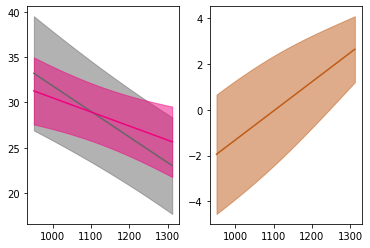

In [127]:
def add_interval(ax, x_data, y_data, y_height):
    line = ax.errorbar(x_data, y_data, yerr=y_height, uplims=True)
    return ax

df_prog_base = pd.read_stata('tmp/margins_base_prog_bl.dta')
df_prog_fup = pd.read_stata('tmp/margins_base_prog_fup.dta')
df_prog_base
df_prog_fup




df_sub = df_prog_fup.apply(lambda row: row - df_prog_base.iloc[0], axis=1)
df_sub['int_base_t1_fup'] = df_prog_fup['int_base_t1_fup']

margins = df_prog_fup[[col for col in df_prog_fup.columns.tolist() if 'margin' in col]]
ci_lb = df_prog_fup[[col for col in df_prog_fup.columns.tolist() if 'ci_lb' in col]]
ci_ub = df_prog_fup[[col for col in df_prog_fup.columns.tolist() if 'ci_ub' in col]]

diag_marg = margins.values[[np.arange(margins.shape[0])]*2]
diag_ci_lb = ci_lb.values[[np.arange(ci_lb.shape[0])]*2]
diag_ci_ub = ci_ub.values[[np.arange(ci_ub.shape[0])]*2]

base_margins = df_prog_base[[col for col in df_prog_base.columns.tolist() if 'margin' in col]].squeeze()
base_mcilb = df_prog_base[[col for col in df_prog_base.columns.tolist() if 'ci_lb' in col]].squeeze()
base_mciub = df_prog_base[[col for col in df_prog_base.columns.tolist() if 'ci_ub' in col]].squeeze()


sub_marg = diag_marg - base_margins

sub_ci_lb = diag_ci_lb - base_mcilb
sub_ci_ub = diag_ci_ub - base_mciub

int_base_t1_time = df_sub['int_base_t1_fup']
x_cb = int_base_t1_time.values

cmap = plt.get_cmap("Accent_r")

fig1, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(x_cb, base_margins, alpha = 1, color=cmap(0))
ax1.fill_between(x_cb, base_mcilb, base_mciub, alpha = 0.5, color=cmap(0))

ax1.plot(x_cb, diag_marg, alpha = 1, color=cmap(2))
ax1.fill_between(x_cb, diag_ci_lb, diag_ci_ub, alpha = 0.5, color=cmap(2))


#fup_0_margins = np.ones_like(margins[1]) * margins[1, np.abs(x_cb - 0) < 1e-6]

#ax1.errorbar(0, base_margins[0],
#             yerr=fup_0_margins[0] - base_margins[0],
#             lolims=True,
#            dash_capstyle='butt')

fig1.show()

#ax2plot(x_cb, sub_margins, alpha = 1, color=cmap(1)
#ax1.fill_between(x_cb, base_mcilb, base_mciub, alpha = 0.5, color=cmap(1)

ax2.plot(x_cb, sub_marg, alpha = 1, color=cmap(1))
ax2.fill_between(x_cb, sub_ci_lb, sub_ci_ub, alpha = 0.5, color=cmap(1))


#fup_0_margins = np.ones_like(margins[1]) * margins[1, np.abs(x_cb - 0) < 1e-6]

#ax1.errorbar(0, base_margins[0],
#             yerr=fup_0_margins[0] - base_margins[0],
#             lolims=True,
#            dash_capstyle='butt')

fig1.show()

In [10]:
origin = 'lower'

delta = 0.025

x = y = np.arange(-3.0, 3.01, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

nr, nc = Z.shape

# put NaNs in one corner:
Z[-nr // 6:, -nc // 6:] = np.nan
# contourf will convert these to masked


Z = np.ma.array(Z)
# mask another corner:
Z[:nr // 6, :nc // 6] = np.ma.masked

In [11]:
X

array([[-3.   , -2.975, -2.95 , ...,  2.95 ,  2.975,  3.   ],
       [-3.   , -2.975, -2.95 , ...,  2.95 ,  2.975,  3.   ],
       [-3.   , -2.975, -2.95 , ...,  2.95 ,  2.975,  3.   ],
       ...,
       [-3.   , -2.975, -2.95 , ...,  2.95 ,  2.975,  3.   ],
       [-3.   , -2.975, -2.95 , ...,  2.95 ,  2.975,  3.   ],
       [-3.   , -2.975, -2.95 , ...,  2.95 ,  2.975,  3.   ]])

In [12]:
Y

array([[-3.   , -3.   , -3.   , ..., -3.   , -3.   , -3.   ],
       [-2.975, -2.975, -2.975, ..., -2.975, -2.975, -2.975],
       [-2.95 , -2.95 , -2.95 , ..., -2.95 , -2.95 , -2.95 ],
       ...,
       [ 2.95 ,  2.95 ,  2.95 , ...,  2.95 ,  2.95 ,  2.95 ],
       [ 2.975,  2.975,  2.975, ...,  2.975,  2.975,  2.975],
       [ 3.   ,  3.   ,  3.   , ...,  3.   ,  3.   ,  3.   ]])

In [13]:
Z

masked_array(
  data=[[--, --, --, ..., 3.599155569968979e-08, 3.0814304924273304e-08,
         2.6337652244551682e-08],
        [--, --, --, ..., 4.1491103375109785e-08, 3.550769947688349e-08,
         3.033546093884205e-08],
        [--, --, --, ..., 4.7750978536971496e-08, 4.0846345515118985e-08,
         3.487957680446272e-08],
        ...,
        [3.599155569968979e-08, 4.1491103375109785e-08,
         4.7750978536971496e-08, ..., nan, nan, nan],
        [3.0814304924273304e-08, 3.550769947688349e-08,
         4.0846345515118985e-08, ..., nan, nan, nan],
        [2.6337652244551682e-08, 3.033546093884205e-08,
         3.487957680446272e-08, ..., nan, nan, nan]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, Fa

In [40]:
maskout.shape

(265, 50)

In [43]:
z_unmasked.shape

(265, 50)

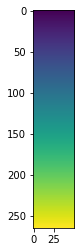

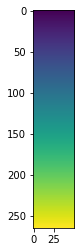

In [47]:
plt.imshow(cont_z)
plt.show()
plt.imshow(z_unmasked)